### Guided Project:
# Winning Jeopardy

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for a few decades, and is a major force in popular culture. If you need help at any point, you can consult our solution notebook [here](https://github.com/dataquestio/solutions/blob/master/Mission210Solution.ipynb).<br>

Let's say you want to compete on Jeopardy, and you're looking for any edge you can get to win. In this project, you'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.<br>

The dataset is named `jeopardy.csv`, and contains `20000` rows from the beginning of a full dataset of Jeopardy questions, which you can download [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file). Here's the beginning of the file:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

%matplotlib inline

In [2]:
jeopardy = pd.read_csv('data/jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
jeopardy.shape

(19999, 7)

As you can see, each row in the dataset represents a single question on a single episode of Jeopardy. Here are explanations of each column:

* `Show Number` -- the Jeopardy episode number of the show this question was in.
* `Air Date` -- the date the episode aired.
* `Round` -- the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
* `Category` -- the category of the question.
* `Value` -- the number of dollars answering the question correctly is worth.
* `Question` -- the text of the question.
* `Answer` -- the text of the answer.

## Jeopardy questions

In [4]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [5]:
columns_nonspace = ['Show Number', 'Air Date', 'Round', 'Category',
                   'Value', 'Question', 'Answer']
col_rename_map = {org:new for (org, new) in zip(jeopardy.columns, columns_nonspace)}

col_rename_map

{' Air Date': 'Air Date',
 ' Answer': 'Answer',
 ' Category': 'Category',
 ' Question': 'Question',
 ' Round': 'Round',
 ' Value': 'Value',
 'Show Number': 'Show Number'}

In [6]:
jeopardy = jeopardy.rename(columns=col_rename_map)
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [7]:
# check data types of each column
for col in jeopardy.columns:
    print(col, '(datatype) :', jeopardy[col].dtype)

Show Number (datatype) : int64
Air Date (datatype) : object
Round (datatype) : object
Category (datatype) : object
Value (datatype) : object
Question (datatype) : object
Answer (datatype) : object


## Normalizing text

Before you can start doing analysis on the Jeopardy questions, you need to normalize all of the text columns (the `Question` and `Answer` columns). We covered normalization before, but the idea is to ensure that you lowercase words and remove punctuation so `Don't` and `don't` aren't considered to be different words when you compare them.

In [8]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    text = text.replace('  ', ' ')
    
    return text

jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)

In [9]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams


## Normalizing columns
Now that you've normalized the text columns, there are also some other columns to normalize.

* The `Value` column **should also be numeric**, to allow you to manipulate it more easily. You'll need to remove the dollar sign from the beginning of each value and convert the column from text to numeric.

* The `Air Date` column **should also be a datetime**, not a string, to enable you to work with it more easily.

In [10]:
jeopardy.Value.unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$1200', '$1600',
       '$2000', '$3,200', 'None', '$5,000', '$100', '$300', '$500',
       '$1,000', '$1,500', '$1,200', '$4,800', '$1,800', '$1,100',
       '$2,200', '$3,400', '$3,000', '$4,000', '$1,600', '$6,800',
       '$1,900', '$3,100', '$700', '$1,400', '$2,800', '$8,000', '$6,000',
       '$2,400', '$12,000', '$3,800', '$2,500', '$6,200', '$10,000',
       '$7,000', '$1,492', '$7,400', '$1,300', '$7,200', '$2,600',
       '$3,300', '$5,400', '$4,500', '$2,100', '$900', '$3,600', '$2,127',
       '$367', '$4,400', '$3,500', '$2,900', '$3,900', '$4,100', '$4,600',
       '$10,800', '$2,300', '$5,600', '$1,111', '$8,200', '$5,800', '$750',
       '$7,500', '$1,700', '$9,000', '$6,100', '$1,020', '$4,700',
       '$2,021', '$5,200', '$3,389'], dtype=object)

In [11]:
def normalize_dollar(text):
    try:
        return int(text.replace('$','').replace(',',''))
    except:    
        return 0
    
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_dollar)

In [12]:
jeopardy['clean_value'].unique()

array([  200,   400,   600,   800,  2000,  1000,  1200,  1600,  3200,
           0,  5000,   100,   300,   500,  1500,  4800,  1800,  1100,
        2200,  3400,  3000,  4000,  6800,  1900,  3100,   700,  1400,
        2800,  8000,  6000,  2400, 12000,  3800,  2500,  6200, 10000,
        7000,  1492,  7400,  1300,  7200,  2600,  3300,  5400,  4500,
        2100,   900,  3600,  2127,   367,  4400,  3500,  2900,  3900,
        4100,  4600, 10800,  2300,  5600,  1111,  8200,  5800,   750,
        7500,  1700,  9000,  6100,  1020,  4700,  2021,  5200,  3389])

In [13]:
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

## Answers in questions

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

* How often the answer is deducible from the question.
* How often new questions are repeats of older questions.

You can answer the second question by seeing how often complex words (> 6 characters) reoccur. You can answer the first question by seeing how many times words in the answer also occur in the question. We'll work on the first question now, and come back to the second.

In [14]:
def count_answer_occurring(row):
    
    # Split the clean_answer column on the space character ()
    split_answer = row['clean_answer'].split(' ')
    
    # Split the clean_question column on the space character ()
    split_question = row['clean_question'].split(' ')
    
    match_count = 0
    
    if 'the' in split_answer:
        split_answer.remove('the')
    
    #  This prevents a division by zero error later
    if len(split_answer) == 0:
        return 0
    
    for sp in split_answer:
        if sp in split_question:
            match_count += 1
            
    return match_count / len(split_answer)

jeopardy['answer_in_question'] = jeopardy.apply(count_answer_occurring, axis=1)

In [15]:
# answer_in_question column unique values
jeopardy['answer_in_question'].unique()

array([ 0.        ,  0.5       ,  0.33333333,  0.2       ,  0.66666667,
        1.        ,  0.25      ,  0.6       ,  0.16666667,  0.75      ,
        0.4       ,  0.57142857,  0.14285714,  0.42857143,  0.125     ,
        0.3       ,  0.28571429,  0.11111111,  0.44444444,  0.18181818,
        0.875     ,  0.35      ,  0.8       ])

In [16]:
# mean of answer_in_question column
jeopardy['answer_in_question'].mean()

0.058989464624746392

In [17]:
# observation probability of answer occurring in question
jeopardy[jeopardy['answer_in_question'] != 0].shape[0] / jeopardy.shape[0]

0.12620631031551577

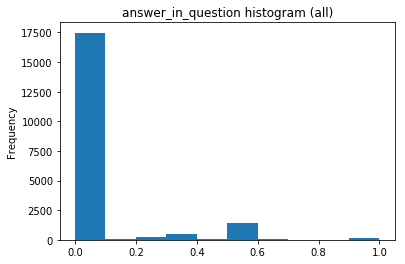

In [18]:
plt.title('answer_in_question histogram (all)')
jeopardy['answer_in_question'].plot(kind='hist')
plt.show()

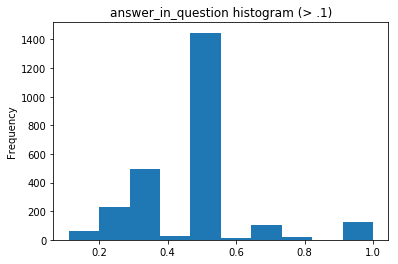

In [19]:
plt.title('answer_in_question histogram (> .1)')
jeopardy['answer_in_question'][jeopardy['answer_in_question']>0.1].plot(kind='hist')
plt.show()

### Note
* Observation probability for occurring answer in each word of question
  * 0.058
  
* Observation probability for answer occurred in question
  * 0.126

## Recycled questions

Let's say you want to investigate **how often new questions are repeats of older ones**. You can't completely answer this, because you only have about `10%` of the full Jeopardy question dataset, but you can investigate it at least.<br>

To do this, you can:

* Sort `jeopardy` in order of ascending air date.
* Maintain a set called `terms_used` that will be empty initially.
* Iterate through each row of `jeopardy`.
* Split `clean_question` into words, remove any word shorter than 6 characters, and check if each word occurs in `terms_used`.
  * If it does, increment a counter.
  * Add each word to `terms_used`.

This will enable you to check if the terms in questions have been used previously or not. Only looking at words greater than `6` characters enables you to filter out words like `the` and `than`, which are commonly used, but don't tell you a lot about a question.

In [20]:
# unique lengths of clean answers
jeopardy['clean_answer'].apply(lambda x: len(x)).unique()

array([ 10,   7,   9,  14,  12,  19,   6,  11,   3,  17,  50,  18,  16,
         2,   5,   8,  26,  15,  13,   4,  21,  28,  22,  27,  20,  30,
        55,  23,   1,  24,  33,  25,  37,  36,  32,  45,  38,  35,  31,
        29,  52,  51,  34,  41,  80,  39,  59,  44,  40,  43,  47,  42,
        46,  64,  54,  58,  56,  57,  49,  75,  48,  70,  61,  67, 125,  69])

In [21]:
jeopardy = jeopardy.sort_values(by='Air Date')

In [22]:
question_overlap = []
terms_used = set()
for i, row in jeopardy.iterrows():
        
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        
        for word in split_question:
            if word in terms_used:
                match_count += 1
        
        for word in split_question:
            terms_used.add(word)
        
        if len(split_question) > 0:
            match_count /= len(split_question)
        
        question_overlap.append(match_count)

jeopardy["question_overlap"] = question_overlap
jeopardy["question_overlap"].mean()

0.68762605921698017

## [Additional Step] Custom word filtering function
Find a better way to **eliminate non-informative words** than just removing words that are less than 6 characters long. 

* **takes in** : a list of strings split by empty space(' ')
* **returns** : filtered list of strings
  * [**what to filter**]
  * (1) a list of stopwords
    * from [here](http://xpo6.com/list-of-english-stop-words/)
  * (2) too-many-occurred words
    * remove words that occur in more than {?}% of questions

### Check the lengths of clean_question strings
* to determine threshold for 'too many occurred'

In [23]:
jeopardy['clean_question'].apply(lambda x: len(x)).mean()

81.741537076853845

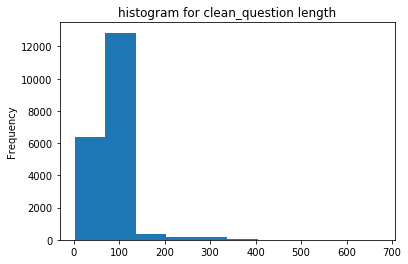

In [24]:
plt.title('histogram for clean_question length')
jeopardy['clean_question'].apply(lambda x: len(x)).plot(kind='hist')

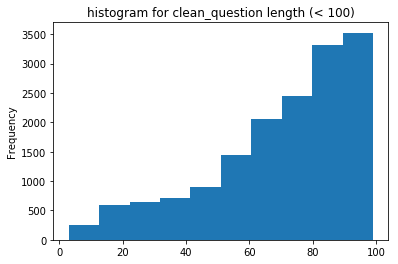

In [25]:
clean_question_leng = jeopardy['clean_question'].apply(lambda x: len(x))

plt.title('histogram for clean_question length (< 100)')
clean_question_leng[clean_question_leng < 100].plot(kind='hist')

### If length of clean_question is 10, just 1 occurrence is counted as 10% occurrence proportion.
* Since the overall length of question is somewhat short (mean=82 chars),
  * better not use 'too-many-occurred' standard!

In [26]:
stopwords = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also",
                  "although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", 
                  "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", 
                  "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", 
                  "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", 
                  "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", 
                  "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", 
                  "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", 
                  "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", 
                  "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", 
                  "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", 
                  "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", 
                  "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", 
                  "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", 
                  "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", 
                  "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", 
                  "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", 
                  "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", 
                  "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the", "i", ""
]

In [27]:
def filter_words(split_list):
    
    split = split_list[:]
    split_to_return = split_list[:]
    
    '''
    dict_count = {}
    dict_prop = {}
    freq_occurred = []
    
    # create dictionary to count occurrences by word
    for word in split:
        if word in dict_count:
            dict_count[word] += 1
        else:
            dict_count[word] = 1
    
    total_occurs = len(split)
    
    # filter words if occur proportion is eq/lt than .05
    for key in dict_count:
        if dict_count[key]/total_occurs > .5:
            freq_occurred.append(key)
            
    '''
    
    for word in split:
        # if word in input 'split'  not in freq_occurred or in stopwords,
        # remove the word from 'split'.
        
        #if (word in freq_occurred) or (word in stopwords):
        if (word in stopwords):
            split_to_return.remove(word)
            
    return split_to_return

## Re-calculate 'question_overlap'
with using `filter_words` function

In [28]:
question_overlap = []
terms_used = set()
for i, row in jeopardy.iterrows():
        
        split_question = row["clean_question"].split(" ")
        #split_question = [q for q in split_question if len(q) > 5]
        split_question = filter_words(split_question)
        
        match_count = 0
        
        for word in split_question:
            if word in terms_used:
                match_count += 1
        
        for word in split_question:
            terms_used.add(word)
        
        if len(split_question) > 0:
            match_count /= len(split_question)
        
        question_overlap.append(match_count)

jeopardy["question_overlap"] = question_overlap
jeopardy["question_overlap"].mean()

0.7779031276909254

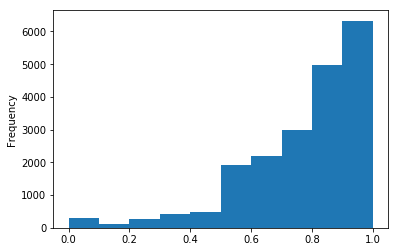

In [29]:
jeopardy['question_overlap'].plot(kind='hist'); plt.show()

In [30]:
jeopardy['Air Year'] = jeopardy['Air Date'].apply(lambda x: x.year)

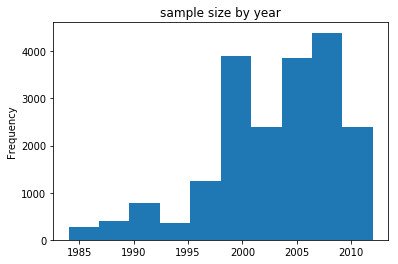

In [31]:
plt.title('sample size by year')
jeopardy['Air Year'].plot(kind='hist', bins=10)

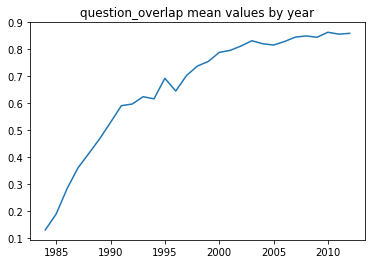

In [32]:
mean_question_overlap_by_year = []

for year in jeopardy['Air Year'].unique():
    
    mean_by_year = jeopardy['question_overlap'][jeopardy['Air Year']==year].mean()
    mean_question_overlap_by_year.append(mean_by_year)

plt.title('question_overlap mean values by year')
plt.plot(range(min(jeopardy['Air Year']), max(jeopardy['Air Year'])+1),\
         mean_question_overlap_by_year); plt.show()

### Note 2
`jeopardy['question_overlap'].mean()`
**Does it mean for questions being recycled?**

> **NOT sure, but worth digging into.**

* We do not consider phrases but only words.
* `question_overlap` value rises as time being passed.
* However, even if we limit the length over 6 characters, the accumulative way to gather term/word itself may cause the overall overlaps by time, at some degree.

## Create `clean_question2` column applying `filter_words` function to `clean_question`

In [33]:
jeopardy['clean_question2'] = jeopardy['clean_question']\
                        .apply(lambda x: ' '.join(filter_words(x.split(' '))))

In [34]:
jeopardy['clean_question2'][jeopardy['clean_question2'] == ''].count()

1

In [35]:
jeopardy[jeopardy['clean_question2'] == '']

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap,Air Year,clean_question2
662,2735,1996-06-21,Jeopardy!,ACTRESSES' FIRST FILMS,$200,"""To Have and Have Not""",(Lauren) Bacall,to have and have not,lauren bacall,200,0.0,0.0,1996,


* For `clean_question` of 662 row, all the words in `clean_question` belong to stopwords.

In [36]:
jeopardy['clean_question2'][jeopardy['clean_question2'] == ''] = 'to have and have not'

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
jeopardy[jeopardy['clean_answer'] == 'lauren bacall']

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap,Air Year,clean_question2
662,2735,1996-06-21,Jeopardy!,ACTRESSES' FIRST FILMS,$200,"""To Have and Have Not""",(Lauren) Bacall,to have and have not,lauren bacall,200,0.0,0.0,1996,to have and have not


## Low value vs. high value questions


Let's say **you only want to study questions that pertain to high value questions instead of low value questions**. This will help you earn more money when you're on Jeopardy.<br>

You can actually figure out which terms correspond to high-value questions using a chi-squared test. You'll first need to narrow down the questions into two categories:

* Low value -- Any row where `Value` is less than `800`.
* High value -- Any row where `Value` is greater than `800`.

You'll then be able to loop through each of the terms from the last screen, `terms_used`, and:

* Find the number of low value questions the word occurs in.
* Find the number of high value questions the word occurs in.
* Find the percentage of questions the word occurs in.
* Based on the percentage of questions the word occurs in, find expected counts.
* Compute the chi squared value based on the expected counts and the observed counts for high and low value questions.

You can then find the words with the biggest differences in usage between high and low value questions, by selecting the words with the highest associated chi-squared values. Doing this for all of the words would take a very long time, so we'll just do it for a small sample now.

In [38]:
def determine_high_val(row):

    if row['clean_value'] > 800: return 1
    else: return 0

jeopardy['high_value'] = jeopardy.apply(determine_high_val, axis=1)
jeopardy['high_value'].unique()    

array([0, 1])

In [39]:
def count_highlow(word):
    
    low_count = 0
    high_count = 0
    
    for idx, row in jeopardy.iterrows():
        
        clean_question_split = row['clean_question2'].split(' ')
        
        if word in clean_question_split:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1

    return high_count, low_count

In [40]:
observed_expected = []

terms_used = list(terms_used)
comparison_terms = terms_used[:5]

for i, term in enumerate(comparison_terms):
    
    try:
        observed_expected.append(count_highlow(term))
    except:
        print(i)

In [41]:
comparison_terms

['council', 'medications', 'sperm', 'moonlight', 'krazy']

In [42]:
observed_expected

[(2, 5), (0, 1), (0, 2), (0, 1), (1, 0)]

## Applying the chi-squared test

In [43]:
high_value_count = jeopardy[jeopardy['high_value']==1].shape[0]
low_value_count = jeopardy[jeopardy['high_value']==0].shape[0]

In [44]:
print(high_value_count, low_value_count)

5734 14265


In [45]:
from scipy.stats import chisquare

In [46]:
chi_squared = []

for high, low in observed_expected:
    
    total = high + low
    total_prop = total / jeopardy.shape[0]
    
    expected_high_value_count = total_prop * high_value_count
    expected_low_value_count = total_prop * low_value_count
    
    chi, pval = chisquare([high, low],
                                  [expected_high_value_count, expected_low_value_count])
    
    chi_squared.append((chi, pval))

In [47]:
chi_squared

[(3.4231707828461518e-05, 0.99533177406483708),
 (0.40196284612688399, 0.52607729857054686),
 (0.80392569225376798, 0.36992223780795708),
 (0.40196284612688399, 0.52607729857054686),
 (2.4877921171956752, 0.11473257634454047)]

### Perform the chi-squared test across more terms to see what terms have larger differences. This is hard to do currently because the code is slow, but here are some ideas:
* Use the apply method to make the code that calculates frequencies more efficient.
* Only select terms that have high frequencies across the dataset, and ignore the others.

### Count terms with high frequency across dataset

In [75]:
term_freq_dict = {}

def grab_high_freq(text):
    
    split_question = text.split(" ")
    split_question = filter_words(split_question)
    
    for term in split_question:
        
        if term in term_freq_dict:
            term_freq_dict[term] += 1
        else:
            term_freq_dict[term] = 1   

In [76]:
jeopardy['clean_question'].apply(grab_high_freq).head()

19325    None
19301    None
19302    None
19303    None
19304    None
Name: clean_question, dtype: object

In [77]:
terms_freq_tot = pd.Series(term_freq_dict).sort_values(ascending=False)

terms_freq_top100 = terms_freq_tot[:100]
terms_freq_top100.head()

city      581
called    521
2         519
named     513
like      489
dtype: int64

### Exclude numeric values from `terms_freq_tot` dictionary
* Numeric data as question terms are less important information.

In [79]:
for term in term_freq_dict:
    
    try:
        if float(term):
            term_freq_dict[term] = 0
        
    except:
        pass
    

In [80]:
terms_freq_tot = pd.Series(term_freq_dict).sort_values(ascending=False)

terms_freq_top100 = terms_freq_tot[:100]
terms_freq_top100.head(10)

city       581
called     521
named      513
like       489
country    476
man        465
seen       446
new        446
state      443
type       440
dtype: int64

## Low vs. High values for freqently occurred terms (top100)
* Using `.apply()` method

In [87]:
highlow_terms_freq_top100 = pd.Series(terms_freq_top100.index).apply(count_highlow)

In [92]:
highlow_terms_freq_top100.index = terms_freq_top100.index

In [93]:
highlow_terms_freq_top100.head()

city       (151, 407)
called     (168, 346)
named      (177, 325)
like       (136, 343)
country    (141, 332)
dtype: object

## Calculate chi-square p-value for each highlow

In [99]:
def calc_chi_pval(highlow):
    
    high = highlow[0]
    low = highlow[1]
    
    tot = high + low
    tot_prop = tot / jeopardy.shape[0]
    
    expected_high_value_count = tot_prop * high_value_count
    expected_low_value_count = tot_prop * low_value_count
    
    return chisquare([high, low], [expected_high_value_count, expected_low_value_count])[1]

In [101]:
highlow_pval_terms_freq_top100 = highlow_terms_freq_top100.apply(calc_chi_pval)
highlow_pval_terms_freq_top100[highlow_pval_terms_freq_top100 < .05]

called              4.421572e-02
named               1.099447e-03
type                4.513174e-02
clue                4.138719e-17
used                6.372407e-03
crew                3.807079e-17
known               2.790620e-03
word                3.202600e-03
targetblankherea    1.059112e-04
french              3.003752e-08
king                2.142226e-03
time                2.482286e-02
island              3.590952e-02
john                4.624583e-02
means               4.112388e-02
play                3.934046e-02
river               4.052149e-02
comes               2.122097e-02
star                4.994880e-03
meaning             3.402468e-02
greek               1.003476e-03
latin               4.210003e-06
founded             3.114509e-02
reports             5.883209e-05
targetblankthisa    1.688716e-06
dtype: float64

## Note 3
* Statistically significant terms for high-low value question are as the following:

In [105]:
highlow_pval_terms_freq_top100[highlow_pval_terms_freq_top100 < .05].index

Index(['called', 'named', 'type', 'clue', 'used', 'crew', 'known', 'word',
       'targetblankherea', 'french', 'king', 'time', 'island', 'john', 'means',
       'play', 'river', 'comes', 'star', 'meaning', 'greek', 'latin',
       'founded', 'reports', 'targetblankthisa'],
      dtype='object')

## Additional approach

* Look more into the `Category` column and see if any interesting analysis can be done with it. Some ideas:
  * See which categories appear the most often.
  * Find the probability of each category appearing in each round.

In [113]:
len(jeopardy['Category'].unique())

3581

In [106]:
jeopardy['Category'].unique()

array(['U.S. PRESIDENTS', 'LABOR UNIONS', '1789', ...,
       'WEAPONS OF WORLD WAR II', 'THE LIVING PLANET',
       'SPORTS & THE MOVIES'], dtype=object)

In [112]:
(jeopardy['Category'].value_counts() / jeopardy.shape[0])[:10]

TELEVISION          0.00255
U.S. GEOGRAPHY      0.00250
LITERATURE          0.00225
BEFORE & AFTER      0.00200
HISTORY             0.00200
AMERICAN HISTORY    0.00200
AUTHORS             0.00195
WORD ORIGINS        0.00190
WORLD CAPITALS      0.00185
SPORTS              0.00180
Name: Category, dtype: float64